# Apply morphological operations as post-processing on predicted masks

In [1]:
# IMPORTS

import numpy as np
from pathlib import Path
import glob2
import matplotlib.pyplot as plt
from tqdm import tqdm

from src.visualization.visualization_fct import mask_to_rgb

# CONSTANTS

path = '../data/raw/carseg_data/clean_data/'
path_predictions = '../data/predictions/unet_finetuned_v9_data_augmented_valid/'

In [2]:
# NB OF FILES IN CLEAN DATASET: 3521

all_paths = [ Path(p).absolute() for p in glob2.glob(path + '*') ]
print('Number of files:', len(all_paths))
assert len(all_paths) == 3521

Number of files: 3521


In [3]:
# load all files
all_files = [np.load(f) for f in all_paths]
all_stems = np.array([f.stem for f in all_paths])

In [4]:
# load predictions

all_predictions_paths = [ Path(p).absolute() for p in glob2.glob(path_predictions + '*') ]
all_predictions = [np.load(f) for f in all_predictions_paths]
all_predictions_stems = np.array([f.stem for f in all_predictions_paths])
print('Number of files:', len(all_predictions_paths))

Number of files: 215


index_pred: 174
Selected file: 934
[0.0, 1.0, 2.0, 3.0, 4.0, 7.0, 8.0]
Shape img: (256, 256, 3)


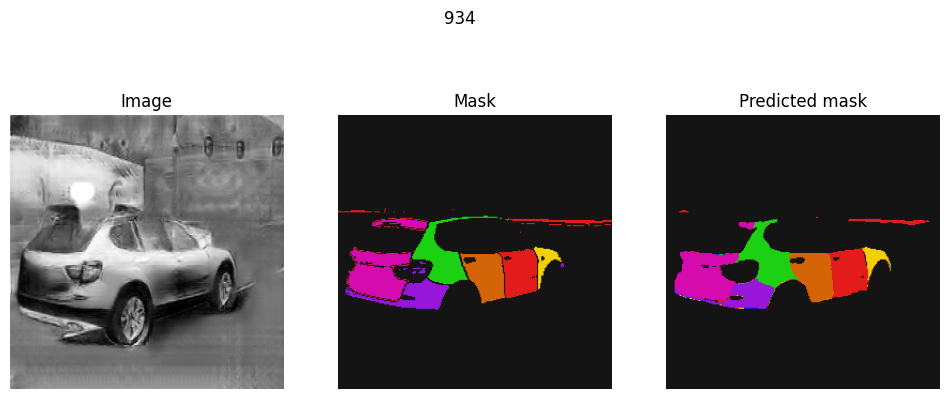

In [5]:
# see a random picture

index_pred = np.random.randint(len(all_predictions_paths)) 
stem_ex = all_predictions_stems[index_pred]
print('index_pred:', index_pred)
print('Selected file:', stem_ex)

index = np.argwhere(all_stems == stem_ex)[0][0]
img_ex = all_files[index]

labels_in_img = list(set(img_ex[3].flatten()))
print(labels_in_img)

anImage = (np.transpose(img_ex[:3], (1, 2, 0))*255).astype(int)
print('Shape img:', anImage.shape)

plt.figure(figsize=(12,5), facecolor='white')
plt.suptitle(stem_ex)

plt.subplot(1,3,1)
plt.title('Image')
plt.imshow(anImage) 
plt.axis(False)

plt.subplot(1,3,2)
plt.title('Mask')
plt.imshow(mask_to_rgb(img_ex[3]), cmap='jet')
plt.axis(False)

plt.subplot(1,3,3)
plt.title('Predicted mask')
plt.imshow(mask_to_rgb(all_predictions[index_pred]), cmap='jet')
plt.axis(False)


plt.show()

## Morphology: opening

In [6]:
import cv2
from torchmetrics.functional import dice
import torch

RECALL:
```python
_MASK_NAMES_ ={
    0:'background', #black #background
    1:'front_door', #red #front_door
    2:'back_door', #orange #back_door
    3:'front_side', #yellow #front_side
    4:'back_side', #green #back_side
    5:'front_bumper ', #turquoise #front_bumper 
    6:'bonnet', #blue #bonnet #capot
    7:'back_bumper', #purple #back_bumper
    8:'trunk', #pink #trunk #coffre
}
```

In [58]:
selected_class = 0

kernel_type_opening = cv2.MORPH_ELLIPSE #cv2.MORPH_CROSS  cv2.MORPH_RECT cv2.MORPH_ELLIPSE
kernel_size_opening = 3

kernel_type_closing = cv2.MORPH_ELLIPSE #cv2.MORPH_CROSS  cv2.MORPH_RECT cv2.MORPH_ELLIPSE
kernel_size_closing = 3

In [59]:
binary_mask = img_ex[3]==selected_class
predicted_binary_mask = all_predictions[index_pred] == selected_class

kernel_opening = cv2.getStructuringElement(kernel_type_opening,(kernel_size_opening,kernel_size_opening))
kernel_closing = cv2.getStructuringElement(kernel_type_closing,(kernel_size_closing,kernel_size_closing))

opening = cv2.morphologyEx(predicted_binary_mask.astype(float), cv2.MORPH_OPEN, kernel_opening)
processed_binary_mask = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel_closing)

# compare efficiency of opening morphological operation

dice_before = dice(torch.IntTensor(predicted_binary_mask), torch.IntTensor(binary_mask)).detach().numpy()
dice_after = dice(torch.IntTensor(processed_binary_mask), torch.IntTensor(binary_mask)).detach().numpy()
print('DICE before opening:\t',dice_before)
print('DICE after opening:\t',dice_after)

print('Progress:\t\t', round(100*(dice_after-dice_before)/dice_before, 2),'%')

DICE before opening:	 0.9784851
DICE after opening:	 0.9773712
Progress:		 -0.11 %


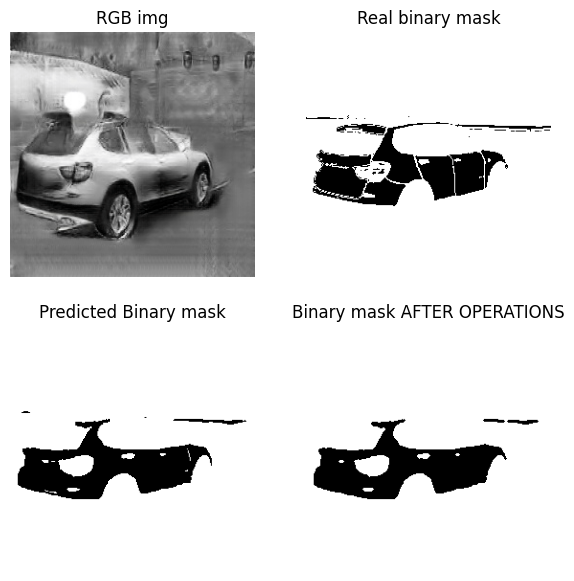

In [60]:
plt.figure(figsize=(7,7), facecolor='white')

plt.subplot(2,2,1)
plt.imshow(anImage) 
plt.axis(False)
plt.title('RGB img')

plt.subplot(2,2,2)
plt.imshow(binary_mask, cmap='gray')
plt.title('Real binary mask')
plt.axis(False)

plt.subplot(2,2,3)
plt.imshow(predicted_binary_mask, cmap='gray')
plt.title('Predicted Binary mask')
plt.axis(False)

plt.subplot(2,2,4)
plt.imshow(processed_binary_mask, cmap='gray')
plt.title('Binary mask AFTER OPERATIONS')
plt.axis(False)

plt.show()

**TODO**

- recombine all openings based on class frequency (?)
- find the best kernel for each class
- apply the best post-processing operations on the test set

### 1. Find the best operations and kernels for each class

In [10]:
def post_processing(aBinaryMask, aListOfMorphOps):
    # ex: aListOfMorphOps = [ (cv2.MORPH_OPEN, cv2.MORPH_ELLIPSE, 3) ]
    processed_mask = aBinaryMask.astype(float)
    for morphType, kernelType, kernelSize in aListOfMorphOps:
        kernel = cv2.getStructuringElement(kernelType,(kernelSize,kernelSize))
        processed_mask = cv2.morphologyEx(processed_mask, morphType, kernel)
    return processed_mask

def get_morph_ops(version='a'):
    # morphType: cv2.MORPH_OPEN  cv2.MORPH_CLOSE
    # kernelType: cv2.MORPH_CROSS  cv2.MORPH_RECT cv2.MORPH_ELLIPSE
    # return: aListOfMorphOps = [ (morphType, kernelType, kernelSize) ]
    if version == 'a':
        morphList = [
            (cv2.MORPH_OPEN, cv2.MORPH_ELLIPSE, 3),
            (cv2.MORPH_CLOSE, cv2.MORPH_ELLIPSE, 3)
        ]
    return morphList

def get_dice_difference(realMask, beforeMask, afterMask):
    dice_before = dice(torch.IntTensor(beforeMask), torch.IntTensor(realMask)).detach().numpy()
    dice_after = dice(torch.IntTensor(afterMask), torch.IntTensor(realMask)).detach().numpy()
    return (dice_after-dice_before)/dice_before

In [11]:
from tqdm import tqdm

**To test**

For each class:

- open, close, open->close, close->open

In [22]:
def run_class_morphological_experiment(selected_class, all_morph_ops):
    dice_progress_list = {}
    
    for i in tqdm(range(len(all_predictions_paths))):
        stem_ex = all_predictions_stems[i]
        index = np.argwhere(all_stems == stem_ex)[0][0]
        img_ex = all_files[index]
        labels_in_img = np.array(list(set(img_ex[3].flatten()))).astype(int)

        aMask = img_ex[3]
        aPredictedMask = all_predictions[i]
        
        for key in range(len(all_morph_ops)):
            morph_operations = all_morph_ops[key]
            if selected_class in labels_in_img:
                real_binary_mask = aMask==selected_class
                predicted_binary_mask = aPredictedMask == selected_class
                processed_binary_mask = post_processing(predicted_binary_mask, morph_operations)
                current_dice_score = get_dice_difference(real_binary_mask, predicted_binary_mask, processed_binary_mask)
                if not key in list(dice_progress_list.keys()):
                    dice_progress_list[key] = [current_dice_score]
                else:
                    dice_progress_list[key].append(current_dice_score)
            
    # apply mean
    dice_progress_mean_avg = {k:np.mean(l) for k,l in dice_progress_list.items()}
    return dice_progress_mean_avg

In [23]:
def run_morphological_experiment(all_morph_ops):
    all_results = {}
    for aClass in range(9):
        all_results[aClass] = run_class_morphological_experiment(aClass, all_morph_ops)
    return all_results

In [33]:
def find_better_config_class(aDict):
    best_config = list(sorted(aDict.items(), reverse=True, key=lambda x:x[1]))[0]
    return best_config

def find_better_config(aDictOfResults):
    best_config_return = {}
    for aClass, aDict in aDictOfResults.items():
        best_config_return[aClass] = find_better_config_class(aDict)
    return best_config_return

#### Operation type

```
Class front_door (1): open (avg progress: 0.001062874449416995)
Class back_door (2): open (avg progress: 0.0007312169764190912)
Class front_side (3): open->close (avg progress: 0.0001978728687390685)
Class back_side (4): open->close (avg progress: 2.939819205494132e-05)
Class front_bumper  (5): open (avg progress: 9.711774328025058e-05)
Class bonnet (6): open (avg progress: 2.058217978628818e-05)
Class back_bumper (7): open->close (avg progress: 5.698537643183954e-05)
Class trunk (8): open (avg progress: 7.576122698083054e-06)
```

In [25]:
# open? close? open->close? close->open?
morph_operations_A = [(cv2.MORPH_OPEN, cv2.MORPH_ELLIPSE, 3)]
morph_operations_B = [(cv2.MORPH_CLOSE, cv2.MORPH_ELLIPSE, 3)]
morph_operations_C = [(cv2.MORPH_OPEN, cv2.MORPH_ELLIPSE, 3), (cv2.MORPH_CLOSE, cv2.MORPH_ELLIPSE, 3)]
morph_operations_D = [(cv2.MORPH_CLOSE, cv2.MORPH_ELLIPSE, 3), (cv2.MORPH_OPEN, cv2.MORPH_ELLIPSE, 3)]

all_morph_ops = [morph_operations_A,morph_operations_B,morph_operations_C,morph_operations_D]

all_classes_dice = run_morphological_experiment(all_morph_ops)
best_config_1 = find_better_config(all_classes_dice)

100%|██████████| 215/215 [00:04<00:00, 44.33it/s]


In [27]:
from src.visualization.visualization_fct import get_mask_names

__MASK_NAMES__ = get_mask_names()

In [30]:
for aClass, aTuple in best_config_1.items():
    idx_morph, avg_progress = aTuple
    print(f'Class {__MASK_NAMES__[aClass]} ({aClass}): {idx_morph} (avg progress: {avg_progress})')

Class background (0): 1 (avg progress: -0.0002960228594020009)
Class front_door (1): 0 (avg progress: 0.001062874449416995)
Class back_door (2): 0 (avg progress: 0.0007312169764190912)
Class front_side (3): 2 (avg progress: 0.0001978728687390685)
Class back_side (4): 2 (avg progress: 2.939819205494132e-05)
Class front_bumper  (5): 0 (avg progress: 9.711774328025058e-05)
Class bonnet (6): 0 (avg progress: 2.058217978628818e-05)
Class back_bumper (7): 2 (avg progress: 5.698537643183954e-05)
Class trunk (8): 0 (avg progress: 7.576122698083054e-06)


#### Kernel type

```
Class front_door (1): MORPH_ELLIPSE (avg progress: 0.0007720341673120856)
Class back_door (2): MORPH_RECT (avg progress: 0.0007476946339011192)
Class front_side (3): MORPH_ELLIPSE (avg progress: 8.665673522045836e-05)
Class back_side (4): MORPH_CROSS (avg progress: -0.0002805065887514502)
Class front_bumper  (5): MORPH_ELLIPSE (avg progress: 1.1701322364388034e-06)
Class bonnet (6): MORPH_ELLIPSE (avg progress: -0.00010993198520736769)
Class back_bumper (7): MORPH_ELLIPSE (avg progress: 6.3544343902322e-06)
Class trunk (8): MORPH_ELLIPSE (avg progress: -6.71594898449257e-05)
```

In [41]:
# which kernel type, class 1

selected_class = 1

morph_operations_A = [(cv2.MORPH_OPEN, cv2.MORPH_ELLIPSE, 5)]
morph_operations_B = [(cv2.MORPH_OPEN, cv2.MORPH_RECT, 5)]
morph_operations_C = [(cv2.MORPH_OPEN, cv2.MORPH_CROSS, 5)]

all_morphs_ops_1 = [morph_operations_A, morph_operations_B, morph_operations_C]
dict_best_1 = run_class_morphological_experiment(selected_class, all_morphs_ops_1)
idx_morph,avg_progress  = find_better_config_class(dict_best_1)
print(f'Class {__MASK_NAMES__[selected_class]} ({selected_class}): {idx_morph} (avg progress: {avg_progress})')

100%|██████████| 215/215 [00:07<00:00, 29.47it/s]

Class front_door (1): 0 (avg progress: 0.0007720341673120856)


In [42]:
# which kernel type, class 2

selected_class = 2

morph_operations_A = [(cv2.MORPH_OPEN, cv2.MORPH_ELLIPSE, 3)]
morph_operations_B = [(cv2.MORPH_OPEN, cv2.MORPH_RECT, 3)]
morph_operations_C = [(cv2.MORPH_OPEN, cv2.MORPH_CROSS, 3)]

all_morphs_ops_1 = [morph_operations_A, morph_operations_B, morph_operations_C]
dict_best_1 = run_class_morphological_experiment(selected_class, all_morphs_ops_1)
idx_morph,avg_progress  = find_better_config_class(dict_best_1)
print(f'Class {__MASK_NAMES__[selected_class]} ({selected_class}): {idx_morph} (avg progress: {avg_progress})')

100%|██████████| 215/215 [00:05<00:00, 41.97it/s]

Class back_door (2): 1 (avg progress: 0.0007476946339011192)


In [43]:
# which kernel type, class 3

selected_class = 3

morph_operations_A = [(cv2.MORPH_OPEN, cv2.MORPH_ELLIPSE, 5),(cv2.MORPH_CLOSE, cv2.MORPH_ELLIPSE, 5)]
morph_operations_B = [(cv2.MORPH_OPEN, cv2.MORPH_RECT, 5),(cv2.MORPH_CLOSE, cv2.MORPH_RECT, 5)]
morph_operations_C = [(cv2.MORPH_OPEN, cv2.MORPH_CROSS, 5),(cv2.MORPH_CLOSE, cv2.MORPH_CROSS, 5)]

all_morphs_ops_1 = [morph_operations_A, morph_operations_B, morph_operations_C]
dict_best_1 = run_class_morphological_experiment(selected_class, all_morphs_ops_1)
idx_morph,avg_progress  = find_better_config_class(dict_best_1)
print(f'Class {__MASK_NAMES__[selected_class]} ({selected_class}): {idx_morph} (avg progress: {avg_progress})')

100%|██████████| 215/215 [00:07<00:00, 29.56it/s]

Class front_side (3): 0 (avg progress: 8.665673522045836e-05)


In [44]:
# which kernel type, class 4

selected_class = 4

morph_operations_A = [(cv2.MORPH_OPEN, cv2.MORPH_ELLIPSE, 5),(cv2.MORPH_CLOSE, cv2.MORPH_ELLIPSE, 5)]
morph_operations_B = [(cv2.MORPH_OPEN, cv2.MORPH_RECT, 5),(cv2.MORPH_CLOSE, cv2.MORPH_RECT, 5)]
morph_operations_C = [(cv2.MORPH_OPEN, cv2.MORPH_CROSS, 5),(cv2.MORPH_CLOSE, cv2.MORPH_CROSS, 5)]

all_morphs_ops_1 = [morph_operations_A, morph_operations_B, morph_operations_C]
dict_best_1 = run_class_morphological_experiment(selected_class, all_morphs_ops_1)
idx_morph,avg_progress  = find_better_config_class(dict_best_1)
print(f'Class {__MASK_NAMES__[selected_class]} ({selected_class}): {idx_morph} (avg progress: {avg_progress})')

100%|██████████| 215/215 [00:07<00:00, 29.52it/s]

Class back_side (4): 2 (avg progress: -0.0002805065887514502)


In [45]:
# which kernel type, class 5

selected_class = 5

morph_operations_A = [(cv2.MORPH_OPEN, cv2.MORPH_ELLIPSE, 5)]
morph_operations_B = [(cv2.MORPH_OPEN, cv2.MORPH_RECT, 5)]
morph_operations_C = [(cv2.MORPH_OPEN, cv2.MORPH_CROSS, 5)]

all_morphs_ops_1 = [morph_operations_A, morph_operations_B, morph_operations_C]
dict_best_1 = run_class_morphological_experiment(selected_class, all_morphs_ops_1)
idx_morph,avg_progress  = find_better_config_class(dict_best_1)
print(f'Class {__MASK_NAMES__[selected_class]} ({selected_class}): {idx_morph} (avg progress: {avg_progress})')

100%|██████████| 215/215 [00:05<00:00, 39.39it/s]

Class front_bumper  (5): 0 (avg progress: 1.1701322364388034e-06)


In [46]:
# which kernel type, class 6

selected_class = 6

morph_operations_A = [(cv2.MORPH_OPEN, cv2.MORPH_ELLIPSE, 5)]
morph_operations_B = [(cv2.MORPH_OPEN, cv2.MORPH_RECT, 5)]
morph_operations_C = [(cv2.MORPH_OPEN, cv2.MORPH_CROSS, 5)]

all_morphs_ops_1 = [morph_operations_A, morph_operations_B, morph_operations_C]
dict_best_1 = run_class_morphological_experiment(selected_class, all_morphs_ops_1)
idx_morph,avg_progress  = find_better_config_class(dict_best_1)
print(f'Class {__MASK_NAMES__[selected_class]} ({selected_class}): {idx_morph} (avg progress: {avg_progress})')

100%|██████████| 215/215 [00:06<00:00, 33.37it/s]

Class bonnet (6): 0 (avg progress: -0.00010993198520736769)


In [47]:
# which kernel type, class 7

selected_class = 7

morph_operations_A = [(cv2.MORPH_OPEN, cv2.MORPH_ELLIPSE, 5),(cv2.MORPH_CLOSE, cv2.MORPH_ELLIPSE, 5)]
morph_operations_B = [(cv2.MORPH_OPEN, cv2.MORPH_RECT, 5),(cv2.MORPH_CLOSE, cv2.MORPH_RECT, 5)]
morph_operations_C = [(cv2.MORPH_OPEN, cv2.MORPH_CROSS, 5),(cv2.MORPH_CLOSE, cv2.MORPH_CROSS, 5)]

all_morphs_ops_1 = [morph_operations_A, morph_operations_B, morph_operations_C]
dict_best_1 = run_class_morphological_experiment(selected_class, all_morphs_ops_1)
idx_morph,avg_progress  = find_better_config_class(dict_best_1)
print(f'Class {__MASK_NAMES__[selected_class]} ({selected_class}): {idx_morph} (avg progress: {avg_progress})')

100%|██████████| 215/215 [00:07<00:00, 29.49it/s]

Class back_bumper (7): 0 (avg progress: 6.3544343902322e-06)


In [48]:
# which kernel type, class 8

selected_class = 8

morph_operations_A = [(cv2.MORPH_OPEN, cv2.MORPH_ELLIPSE, 5)]
morph_operations_B = [(cv2.MORPH_OPEN, cv2.MORPH_RECT, 5)]
morph_operations_C = [(cv2.MORPH_OPEN, cv2.MORPH_CROSS, 5)]

all_morphs_ops_1 = [morph_operations_A, morph_operations_B, morph_operations_C]
dict_best_1 = run_class_morphological_experiment(selected_class, all_morphs_ops_1)
idx_morph,avg_progress  = find_better_config_class(dict_best_1)
print(f'Class {__MASK_NAMES__[selected_class]} ({selected_class}): {idx_morph} (avg progress: {avg_progress})')

100%|██████████| 215/215 [00:04<00:00, 51.95it/s]

Class trunk (8): 0 (avg progress: -6.71594898449257e-05)


#### Kernel size

3 for all

```
Class front_door (1): 3 (avg progress: 0.001062874449416995)
Class back_door (2): 3 (avg progress: 0.0007476946339011192)
Class front_side (3): 3 (avg progress: 0.0001978728687390685)
Class back_side (4): 3 (avg progress: 2.939819205494132e-05)
Class front_bumper  (5): 3 (avg progress: 9.711774328025058e-05)
Class bonnet (6): 3 (avg progress: 2.058217978628818e-05)
Class back_bumper (7): 3 (avg progress: 5.698537643183954e-05)
Class trunk (8): 3 (avg progress: 7.576122698083054e-06)
```

In [49]:
# which kernel type, class 1

selected_class = 1

morph_operations_A = [(cv2.MORPH_OPEN, cv2.MORPH_ELLIPSE, 1)]
morph_operations_B = [(cv2.MORPH_OPEN, cv2.MORPH_ELLIPSE, 3)]
morph_operations_C = [(cv2.MORPH_OPEN, cv2.MORPH_ELLIPSE, 5)]

all_morphs_ops_1 = [morph_operations_A, morph_operations_B, morph_operations_C]
dict_best_1 = run_class_morphological_experiment(selected_class, all_morphs_ops_1)
idx_morph,avg_progress  = find_better_config_class(dict_best_1)
print(f'Class {__MASK_NAMES__[selected_class]} ({selected_class}): {idx_morph} (avg progress: {avg_progress})')

100%|██████████| 215/215 [00:07<00:00, 29.37it/s]

Class front_door (1): 1 (avg progress: 0.001062874449416995)


In [51]:
# which kernel type, class 2

selected_class = 2

morph_operations_A = [(cv2.MORPH_OPEN, cv2.MORPH_RECT, 1)]
morph_operations_B = [(cv2.MORPH_OPEN, cv2.MORPH_RECT, 3)]
morph_operations_C = [(cv2.MORPH_OPEN, cv2.MORPH_RECT, 5)]

all_morphs_ops_1 = [morph_operations_A, morph_operations_B, morph_operations_C]
dict_best_1 = run_class_morphological_experiment(selected_class, all_morphs_ops_1)
idx_morph,avg_progress  = find_better_config_class(dict_best_1)
print(f'Class {__MASK_NAMES__[selected_class]} ({selected_class}): {idx_morph} (avg progress: {avg_progress})')

100%|██████████| 215/215 [00:04<00:00, 46.80it/s]

Class back_door (2): 1 (avg progress: 0.0007476946339011192)


In [52]:
# which kernel type, class 3

selected_class = 3

morph_operations_A = [(cv2.MORPH_OPEN, cv2.MORPH_ELLIPSE, 1),(cv2.MORPH_CLOSE, cv2.MORPH_ELLIPSE, 1)]
morph_operations_B = [(cv2.MORPH_OPEN, cv2.MORPH_ELLIPSE, 3),(cv2.MORPH_CLOSE, cv2.MORPH_ELLIPSE, 3)]
morph_operations_C = [(cv2.MORPH_OPEN, cv2.MORPH_ELLIPSE, 5),(cv2.MORPH_CLOSE, cv2.MORPH_ELLIPSE, 5)]

all_morphs_ops_1 = [morph_operations_A, morph_operations_B, morph_operations_C]
dict_best_1 = run_class_morphological_experiment(selected_class, all_morphs_ops_1)
idx_morph,avg_progress  = find_better_config_class(dict_best_1)
print(f'Class {__MASK_NAMES__[selected_class]} ({selected_class}): {idx_morph} (avg progress: {avg_progress})')

100%|██████████| 215/215 [00:06<00:00, 34.28it/s]

Class front_side (3): 1 (avg progress: 0.0001978728687390685)


In [53]:
# which kernel type, class 4

selected_class = 4

morph_operations_A = [(cv2.MORPH_OPEN, cv2.MORPH_CROSS, 1),(cv2.MORPH_CLOSE, cv2.MORPH_CROSS, 1)]
morph_operations_B = [(cv2.MORPH_OPEN, cv2.MORPH_CROSS, 3),(cv2.MORPH_CLOSE, cv2.MORPH_CROSS, 3)]
morph_operations_C = [(cv2.MORPH_OPEN, cv2.MORPH_CROSS, 5),(cv2.MORPH_CLOSE, cv2.MORPH_CROSS, 5)]

all_morphs_ops_1 = [morph_operations_A, morph_operations_B, morph_operations_C]
dict_best_1 = run_class_morphological_experiment(selected_class, all_morphs_ops_1)
idx_morph,avg_progress  = find_better_config_class(dict_best_1)
print(f'Class {__MASK_NAMES__[selected_class]} ({selected_class}): {idx_morph} (avg progress: {avg_progress})')

100%|██████████| 215/215 [00:06<00:00, 33.06it/s]

Class back_side (4): 1 (avg progress: 2.939819205494132e-05)


In [54]:
# which kernel type, class 5

selected_class = 5

morph_operations_A = [(cv2.MORPH_OPEN, cv2.MORPH_ELLIPSE, 1)]
morph_operations_B = [(cv2.MORPH_OPEN, cv2.MORPH_ELLIPSE, 3)]
morph_operations_C = [(cv2.MORPH_OPEN, cv2.MORPH_ELLIPSE, 5)]

all_morphs_ops_1 = [morph_operations_A, morph_operations_B, morph_operations_C]
dict_best_1 = run_class_morphological_experiment(selected_class, all_morphs_ops_1)
idx_morph,avg_progress  = find_better_config_class(dict_best_1)
print(f'Class {__MASK_NAMES__[selected_class]} ({selected_class}): {idx_morph} (avg progress: {avg_progress})')

100%|██████████| 215/215 [00:04<00:00, 43.08it/s]

Class front_bumper  (5): 1 (avg progress: 9.711774328025058e-05)


In [55]:
# which kernel type, class 6

selected_class = 6

morph_operations_A = [(cv2.MORPH_OPEN, cv2.MORPH_ELLIPSE, 1)]
morph_operations_B = [(cv2.MORPH_OPEN, cv2.MORPH_ELLIPSE, 3)]
morph_operations_C = [(cv2.MORPH_OPEN, cv2.MORPH_ELLIPSE, 5)]

all_morphs_ops_1 = [morph_operations_A, morph_operations_B, morph_operations_C]
dict_best_1 = run_class_morphological_experiment(selected_class, all_morphs_ops_1)
idx_morph,avg_progress  = find_better_config_class(dict_best_1)
print(f'Class {__MASK_NAMES__[selected_class]} ({selected_class}): {idx_morph} (avg progress: {avg_progress})')

100%|██████████| 215/215 [00:06<00:00, 35.69it/s]

Class bonnet (6): 1 (avg progress: 2.058217978628818e-05)


In [56]:
# which kernel type, class 7

selected_class = 7

morph_operations_A = [(cv2.MORPH_OPEN, cv2.MORPH_ELLIPSE, 1),(cv2.MORPH_CLOSE, cv2.MORPH_ELLIPSE, 1)]
morph_operations_B = [(cv2.MORPH_OPEN, cv2.MORPH_ELLIPSE, 3),(cv2.MORPH_CLOSE, cv2.MORPH_ELLIPSE, 3)]
morph_operations_C = [(cv2.MORPH_OPEN, cv2.MORPH_ELLIPSE, 5),(cv2.MORPH_CLOSE, cv2.MORPH_ELLIPSE, 5)]

all_morphs_ops_1 = [morph_operations_A, morph_operations_B, morph_operations_C]
dict_best_1 = run_class_morphological_experiment(selected_class, all_morphs_ops_1)
idx_morph,avg_progress  = find_better_config_class(dict_best_1)
print(f'Class {__MASK_NAMES__[selected_class]} ({selected_class}): {idx_morph} (avg progress: {avg_progress})')

100%|██████████| 215/215 [00:06<00:00, 32.01it/s]

Class back_bumper (7): 1 (avg progress: 5.698537643183954e-05)


In [57]:
# which kernel type, class 8

selected_class = 8

morph_operations_A = [(cv2.MORPH_OPEN, cv2.MORPH_ELLIPSE, 1)]
morph_operations_B = [(cv2.MORPH_OPEN, cv2.MORPH_ELLIPSE, 3)]
morph_operations_C = [(cv2.MORPH_OPEN, cv2.MORPH_ELLIPSE, 5)]

all_morphs_ops_1 = [morph_operations_A, morph_operations_B, morph_operations_C]
dict_best_1 = run_class_morphological_experiment(selected_class, all_morphs_ops_1)
idx_morph,avg_progress  = find_better_config_class(dict_best_1)
print(f'Class {__MASK_NAMES__[selected_class]} ({selected_class}): {idx_morph} (avg progress: {avg_progress})')

100%|██████████| 215/215 [00:04<00:00, 50.19it/s]

Class trunk (8): 1 (avg progress: 7.576122698083054e-06)


# CONCLUSION

```
Class front_door (1): open MORPH_ELLIPSE 3
Class back_door (2): open MORPH_RECT 3
Class front_side (3): open->close MORPH_ELLIPSE 3
Class back_side (4): open->close MORPH_CROSS 3
Class front_bumper  (5): open MORPH_ELLIPSE 3
Class bonnet (6): open MORPH_ELLIPSE 3
Class back_bumper (7): open->close MORPH_ELLIPSE 3
Class trunk (8): open MORPH_ELLIPSE 3
```